# Fish Classification - Setup and Exploratory Data Analysis

## Project Overview
Building a CNN-based image classification pipeline to classify 31 fish species.

### Dataset Information
- **Classes**: 31 fish species
- **Train**: 8,819 images
- **Validation**: 2,751 images
- **Test**: 1,761 images

### Pipeline Structure
1. Setup and EDA (this notebook)
2. Data Preprocessing & Augmentation
3. CNN Model Training (5+ models)
4. Model Evaluation
5. Ensemble & Final Predictions

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import random
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:

BASE_DIR = os.path.abspath('.')
DATA_DIR = os.path.join(BASE_DIR, 'data', 'raw', 'FishImgDataset')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

REPORTS_DIR = os.path.join(BASE_DIR, 'reports')
FIGURES_DIR = os.path.join(REPORTS_DIR, 'figures')
METRICS_DIR = os.path.join(REPORTS_DIR, 'metrics')
MODELS_DIR = os.path.join(BASE_DIR, 'models', 'cnn')

for dir_path in [REPORTS_DIR, FIGURES_DIR, METRICS_DIR, MODELS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Train directory: {TRAIN_DIR}")
print(f"Validation directory: {VAL_DIR}")
print(f"Test directory: {TEST_DIR}")

## 1. Dataset Overview

In [20]:
def count_images(directory):
    """Count images per class in a directory."""
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VAL_DIR)
test_counts = count_images(TEST_DIR)

CLASSES = sorted(train_counts.keys())
NUM_CLASSES = len(CLASSES)

print(f"Number of classes: {NUM_CLASSES}")
print(f"\nClasses: {CLASSES}")

Number of classes: 31

Classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


In [21]:
dataset_summary = pd.DataFrame({
    'Class': CLASSES,
    'Train': [train_counts[c] for c in CLASSES],
    'Validation': [val_counts[c] for c in CLASSES],
    'Test': [test_counts[c] for c in CLASSES]
})
dataset_summary['Total'] = dataset_summary['Train'] + dataset_summary['Validation'] + dataset_summary['Test']
dataset_summary = dataset_summary.sort_values('Train', ascending=False).reset_index(drop=True)

print("Dataset Summary:")
print("=" * 70)
print(dataset_summary.to_string(index=False))
print("=" * 70)
print(f"\nTotal Train: {dataset_summary['Train'].sum()}")
print(f"Total Validation: {dataset_summary['Validation'].sum()}")
print(f"Total Test: {dataset_summary['Test'].sum()}")
print(f"Grand Total: {dataset_summary['Total'].sum()}")

Dataset Summary:
                Class  Train  Validation  Test  Total
           Grass Carp   1222         378   238   1838
                 Goby    607         189   124    920
       Glass Perchlet    399         124    77    600
          Silver Barb    329         105    64    498
            Knifefish    319         100    65    484
              Catfish    314          97    62    473
              Gourami    312          97    63    472
              Tilapia    302          95    57    454
                Perch    293          91    60    444
         Janitor Fish    286          89    58    433
         Silver Perch    283          88    57    428
           Tenpounder    277          87    56    420
       Freshwater Eel    273          84    55    412
          Indian Carp    262          81    53    396
Long-Snouted Pipefish    256          81    52    389
        Mosquito Fish    256          80    51    387
          Silver Carp    238          75    48    361
           

## 2. Class Distribution Analysis

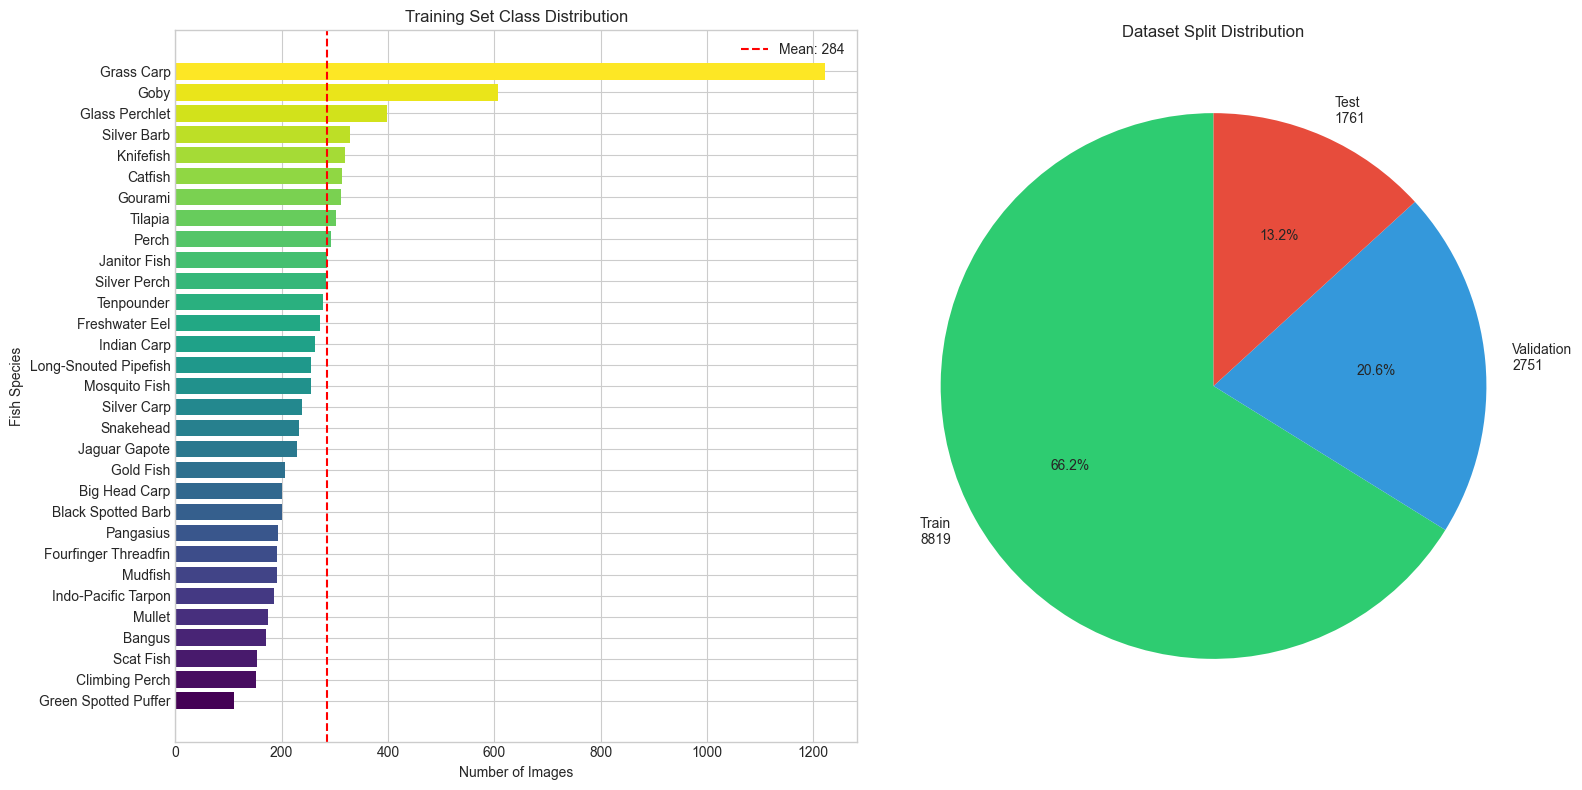

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

colors = plt.cm.viridis(np.linspace(0, 1, NUM_CLASSES))
sorted_df = dataset_summary.sort_values('Train', ascending=True)

axes[0].barh(sorted_df['Class'], sorted_df['Train'], color=colors)
axes[0].set_xlabel('Number of Images')
axes[0].set_ylabel('Fish Species')
axes[0].set_title('Training Set Class Distribution')
axes[0].axvline(x=dataset_summary['Train'].mean(), color='red', linestyle='--', label=f"Mean: {dataset_summary['Train'].mean():.0f}")
axes[0].legend()

train_total = dataset_summary['Train'].sum()
val_total = dataset_summary['Validation'].sum()
test_total = dataset_summary['Test'].sum()
sizes = [train_total, val_total, test_total]
labels = [f'Train\n{train_total}', f'Validation\n{val_total}', f'Test\n{test_total}']
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#3498db', '#e74c3c'])
axes[1].set_title('Dataset Split Distribution')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '01_class_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

In [23]:
imbalance_ratio = dataset_summary['Train'].max() / dataset_summary['Train'].min()
min_class = dataset_summary.loc[dataset_summary['Train'].idxmin(), 'Class']
max_class = dataset_summary.loc[dataset_summary['Train'].idxmax(), 'Class']

print("Class Imbalance Analysis:")
print("=" * 50)
print(f"Minimum samples: {dataset_summary['Train'].min()} ({min_class})")
print(f"Maximum samples: {dataset_summary['Train'].max()} ({max_class})")
print(f"Mean samples: {dataset_summary['Train'].mean():.1f}")
print(f"Median samples: {dataset_summary['Train'].median():.1f}")
print(f"Std deviation: {dataset_summary['Train'].std():.1f}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print("\n⚠️ Significant class imbalance detected!")
print("→ Will use class weights and data augmentation to address this.")

Class Imbalance Analysis:
Minimum samples: 110 (Green Spotted Puffer)
Maximum samples: 1222 (Grass Carp)
Mean samples: 284.5
Median samples: 256.0
Std deviation: 196.4
Imbalance ratio: 11.11:1

⚠️ Significant class imbalance detected!
→ Will use class weights and data augmentation to address this.


## 3. Image Properties Analysis

In [24]:
def analyze_images(directory, sample_per_class=10):
    """Analyze image properties from sample images."""
    widths, heights, aspects, formats, modes = [], [], [], [], []
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:sample_per_class]
            for img_name in images:
                try:
                    img_path = os.path.join(class_path, img_name)
                    with Image.open(img_path) as img:
                        widths.append(img.size[0])
                        heights.append(img.size[1])
                        aspects.append(img.size[0] / img.size[1])
                        formats.append(img.format)
                        modes.append(img.mode)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")
    
    return widths, heights, aspects, formats, modes

widths, heights, aspects, formats, modes = analyze_images(TRAIN_DIR, sample_per_class=20)

print("Image Properties Analysis:")
print("=" * 50)
print(f"Samples analyzed: {len(widths)}")
print(f"\nWidth: {min(widths)} - {max(widths)} (mean: {np.mean(widths):.0f})")
print(f"Height: {min(heights)} - {max(heights)} (mean: {np.mean(heights):.0f})")
print(f"Aspect ratio: {min(aspects):.2f} - {max(aspects):.2f} (mean: {np.mean(aspects):.2f})")
print(f"\nFormats: {Counter(formats)}")
print(f"Color modes: {Counter(modes)}")

Image Properties Analysis:
Samples analyzed: 620

Width: 90 - 5184 (mean: 894)
Height: 69 - 3456 (mean: 587)
Aspect ratio: 0.21 - 4.49 (mean: 1.66)

Formats: Counter({'JPEG': 614, 'PNG': 6})
Color modes: Counter({'RGB': 614, 'RGBA': 6})


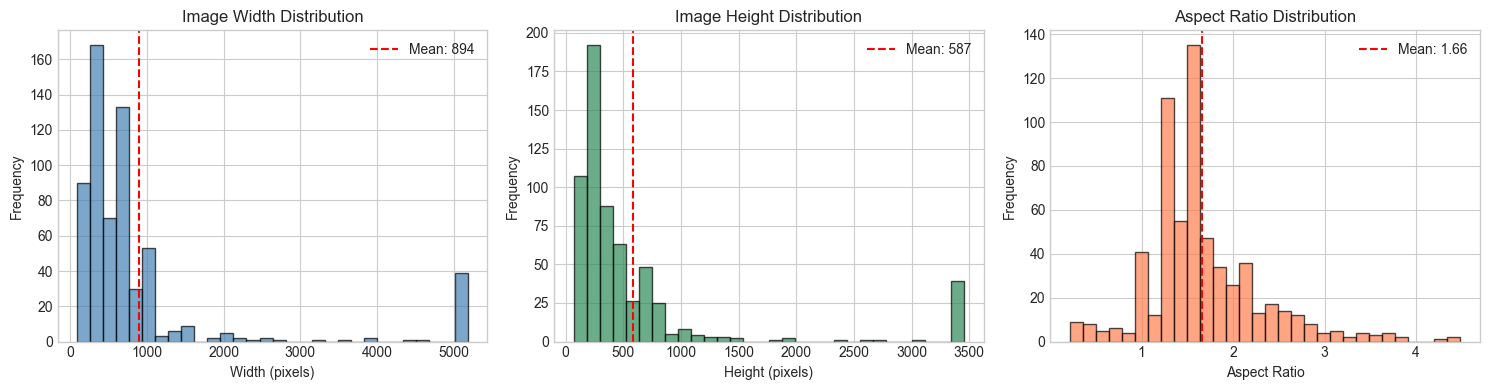

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(widths, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Width Distribution')
axes[0].axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.0f}')
axes[0].legend()

axes[1].hist(heights, bins=30, color='seagreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Height Distribution')
axes[1].axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.0f}')
axes[1].legend()

axes[2].hist(aspects, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Aspect Ratio')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Aspect Ratio Distribution')
axes[2].axvline(np.mean(aspects), color='red', linestyle='--', label=f'Mean: {np.mean(aspects):.2f}')
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_image_properties.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Sample Images Visualization

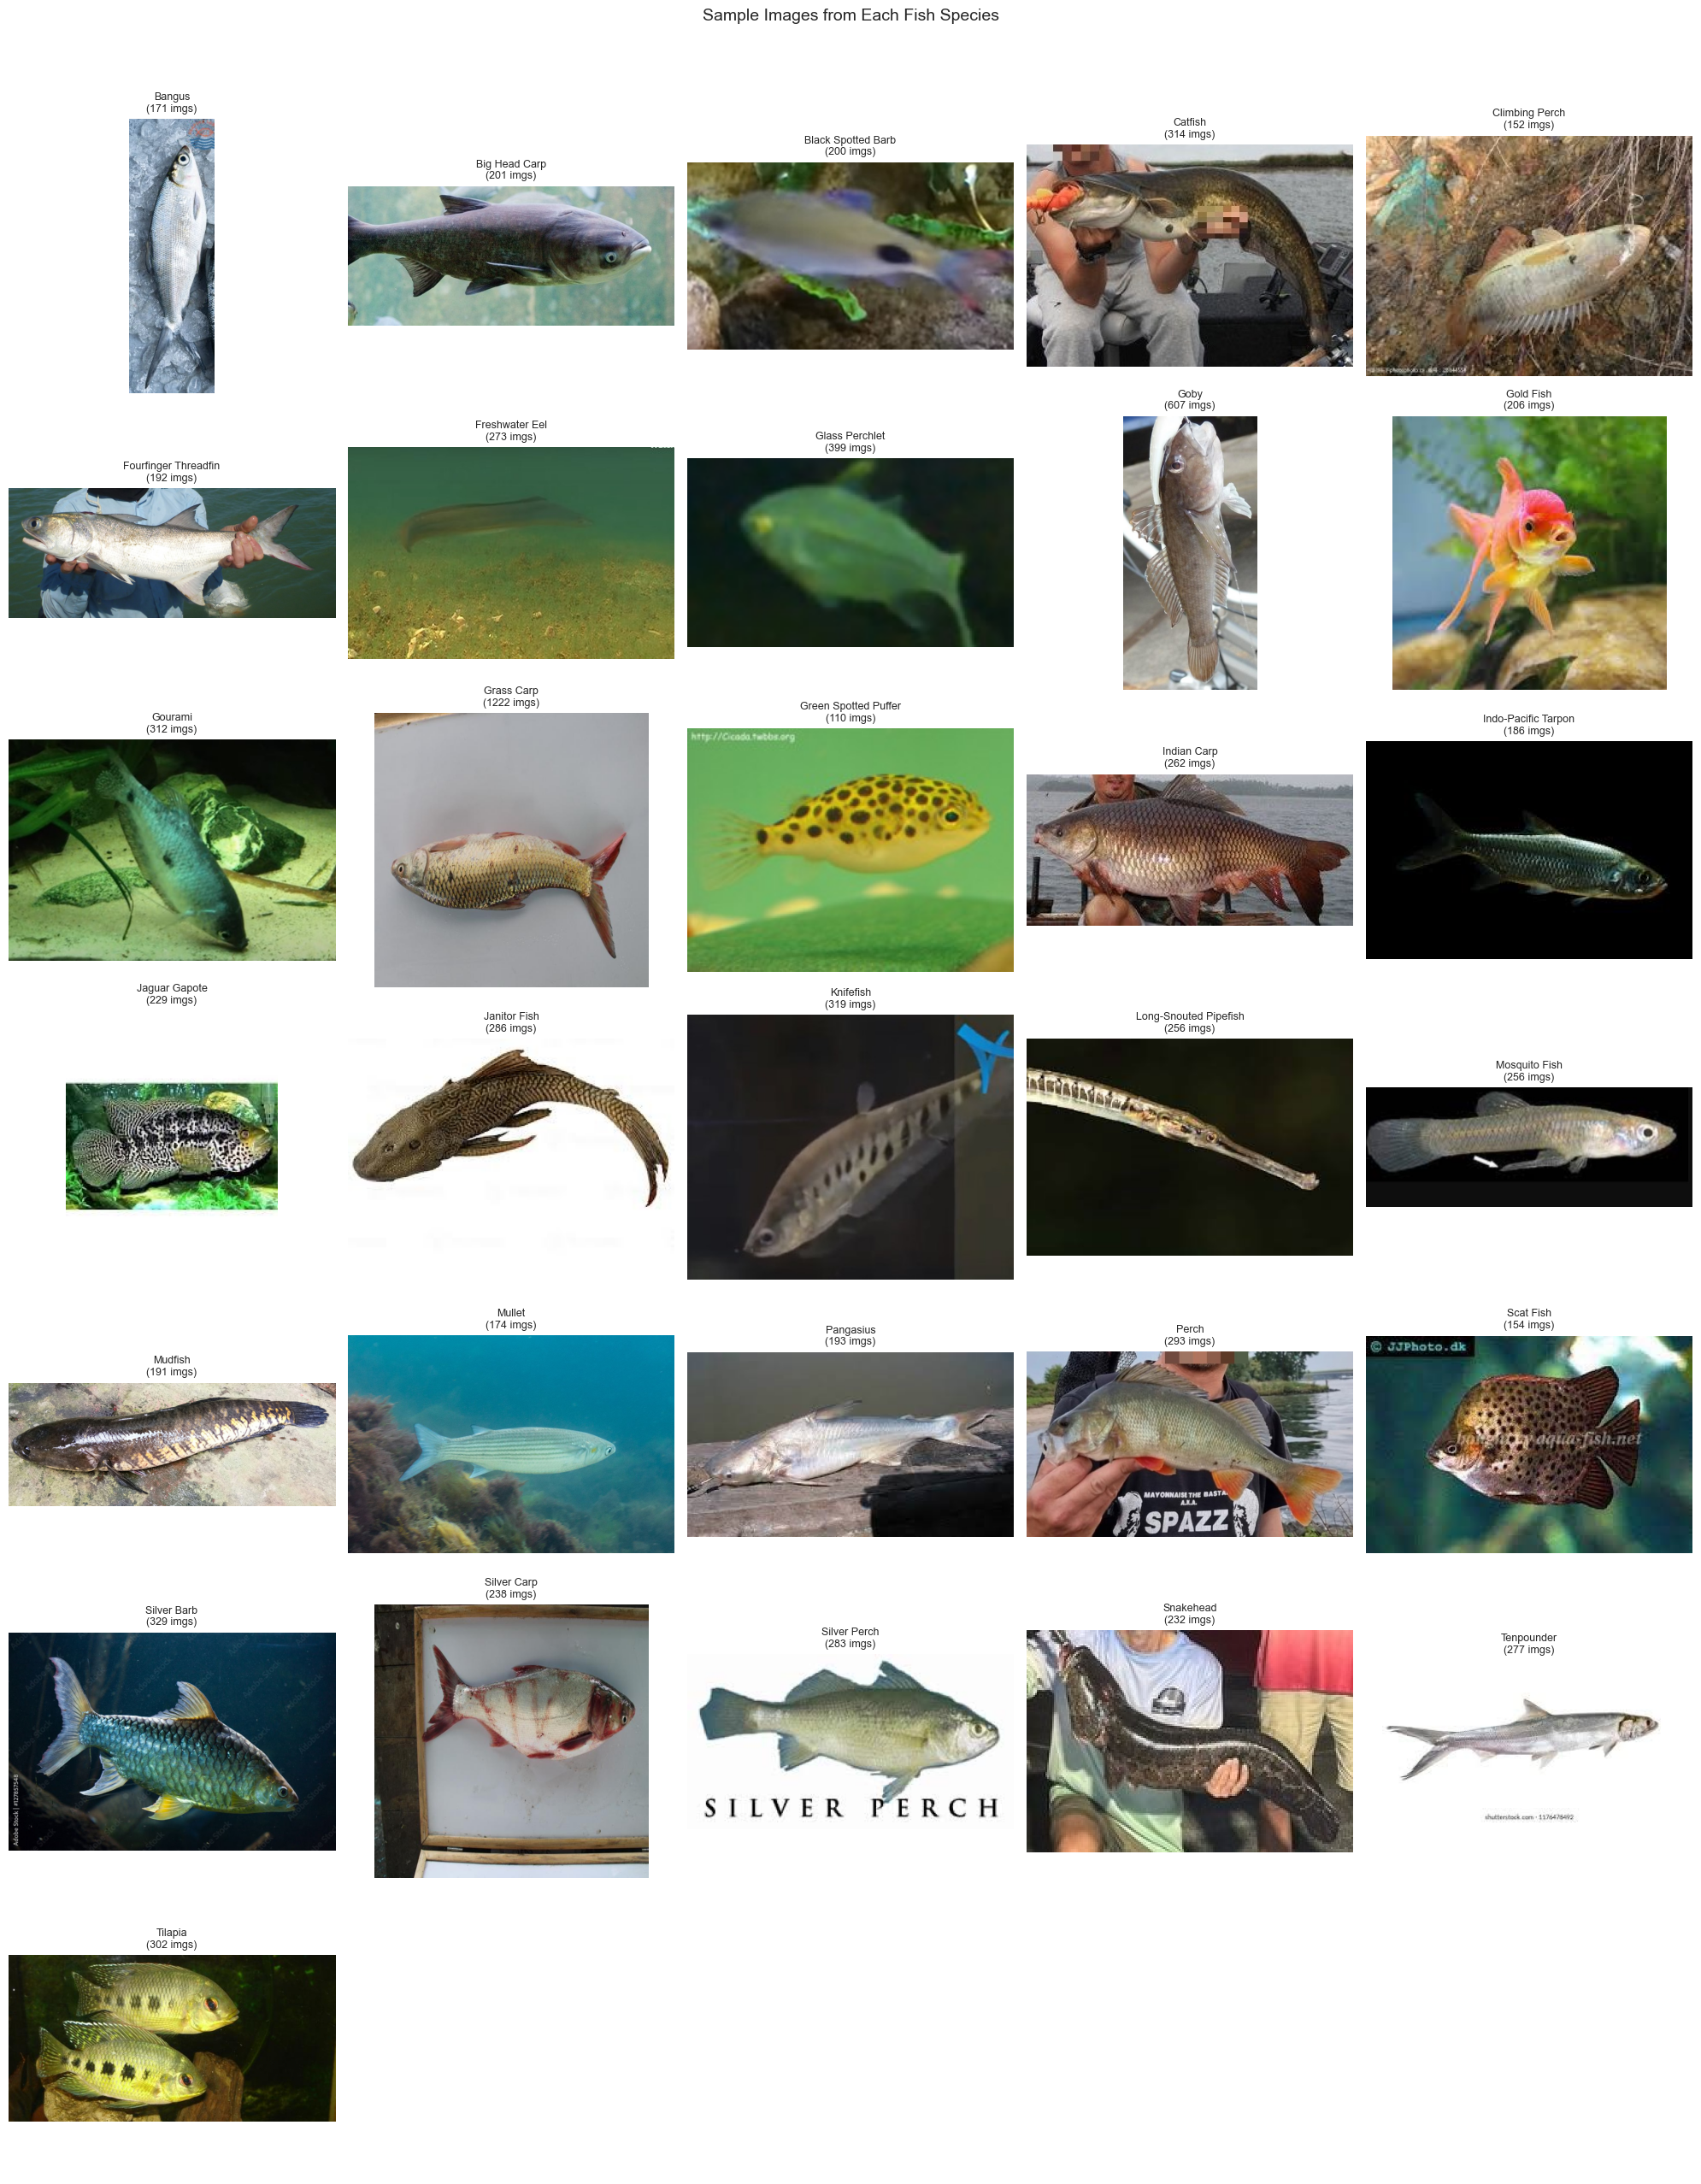

In [26]:
def show_sample_images(directory, classes, samples_per_class=1, figsize=(20, 25)):
    """Display sample images from each class."""
    n_classes = len(classes)
    n_cols = 5
    n_rows = (n_classes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)
        
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{class_name}\n({train_counts[class_name]} imgs)", fontsize=9)
        axes[idx].axis('off')
    
    for idx in range(n_classes, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Sample Images from Each Fish Species', fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

fig = show_sample_images(TRAIN_DIR, CLASSES)
plt.savefig(os.path.join(FIGURES_DIR, '03_sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Configuration

In [ ]:
import json

config = {
    'num_classes': NUM_CLASSES,
    'classes': CLASSES,
    'train_samples': int(dataset_summary['Train'].sum()),
    'val_samples': int(dataset_summary['Validation'].sum()),
    'test_samples': int(dataset_summary['Test'].sum()),
    'class_counts_train': {k: int(v) for k, v in train_counts.items()},
    'imbalance_ratio': float(imbalance_ratio),
    'image_size': [224, 224],
    'batch_size': 32,
    'data_dir': DATA_DIR,
    'train_dir': TRAIN_DIR,
    'val_dir': VAL_DIR,
    'test_dir': TEST_DIR
}

config_path = os.path.join(MODELS_DIR, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"Configuration saved to: {config_path}")
print("\nConfiguration:")
for key, value in config.items():
    if key not in ['classes', 'class_counts_train']:
        print(f"  {key}: {value}")